In [1]:
import pandas as pd
import numpy as np
import os

# Load Data sets

#### Load users

In [2]:
dtypes = {'id': 'str'}
user_file_path = os.path.join('..', 'data_in', 'User.csv')
users = pd.read_csv(user_file_path, dtype=dtypes)
users['dob_fix'] = pd.to_datetime(users.dob, errors='coerce', dayfirst=True)
users.rename(columns={'id': 'user_id'}, inplace=True)
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6729 entries, 0 to 6728
Data columns (total 5 columns):
user_id                  6729 non-null object
dob                      440 non-null object
cycle_length_initial     6729 non-null int64
period_length_initial    6729 non-null int64
dob_fix                  345 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 262.9+ KB


#### Check users
- still some issues

In [3]:
real_dates = users[users.dob_fix.notna()]
birth_years = real_dates.groupby(pd.Grouper(key='dob_fix', freq='y')).size().reset_index()
#lines_births = cm.line_chart(birth_years, x_col='dob_fix', y_col=0)
birth_years.plot.line(x='dob_fix', y=0)

#### Load Symptoms

In [4]:
file_path = os.path.join('..', 'data_in', 'Symptom.csv')
symptoms = pd.read_csv(file_path)
symptoms.rename(columns={'id': 'symptom_id'}, inplace=True)
symptoms['date_fix'] = pd.to_datetime(symptoms.date, errors='coerce', dayfirst=True)
symptoms.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13512 entries, 0 to 13511
Data columns (total 14 columns):
symptom_id    13512 non-null int64
user_id       13512 non-null int64
acne          13512 non-null int64
backache      13512 non-null int64
bloating      13512 non-null int64
cramp         13512 non-null int64
diarrhea      13512 non-null int64
dizzy         13512 non-null int64
headache      13512 non-null int64
mood          13512 non-null int64
nausea        13512 non-null int64
sore          13512 non-null int64
date          13512 non-null object
date_fix      13511 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(12), object(1)
memory usage: 1.4+ MB


#### User responses

In [5]:
symptoms.groupby('user_id').size().describe()

count    3953.000000
mean        3.418163
std         6.645441
min         1.000000
25%         1.000000
50%         1.000000
75%         3.000000
max       182.000000
dtype: float64

#### Times

records with dates before today: 12


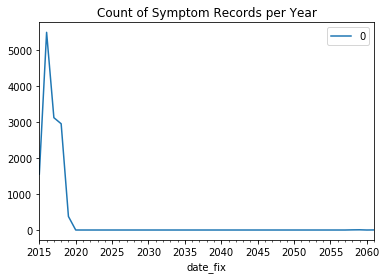

In [6]:
print('records with dates before today:', symptoms[symptoms.date_fix > pd.to_datetime('today')].shape[0])
#plot vals
syptom_years = symptoms.groupby([pd.Grouper(key='date_fix', freq='y')]).size().reset_index()
syptom_years.plot.line(x='date_fix', y=0, title='Count of Symptom Records per Year')

#### Read Period Data

In [7]:
file_path = os.path.join('..', 'data_in', 'Period.csv')
periods = pd.read_csv(file_path)
periods.rename(columns={'id': 'period_id'}, inplace=True)
periods.columns = periods.columns.str.lower()
periods['start_date_fix'] = pd.to_datetime(periods.start_date, errors='coerce', dayfirst=True)
periods['end_date_fix'] = pd.to_datetime(periods.end_date, errors='coerce', dayfirst=True)
periods.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34942 entries, 0 to 34941
Data columns (total 6 columns):
period_id         34942 non-null int64
start_date        34939 non-null object
end_date          32168 non-null object
user_id           34942 non-null int64
start_date_fix    34934 non-null datetime64[ns]
end_date_fix      32163 non-null datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(2)
memory usage: 1.6+ MB


#### add period length

In [8]:
periods['length'] = periods.end_date_fix - periods.start_date_fix
periods['length'].describe()

count                     32163
mean     4 days 20:06:09.368529
std      5 days 18:08:52.487068
min          -22 days +00:00:00
25%             4 days 00:00:00
50%             5 days 00:00:00
75%             6 days 00:00:00
max           383 days 00:00:00
Name: length, dtype: object

#### Periods with dates over today
- why would there be data from 1958-61

In [9]:
periods.loc[periods.start_date_fix > pd.to_datetime('today'), 'start_date'].str[-2:].value_counts()

59    20
60    10
61     7
58     3
Name: start_date, dtype: int64

#### A lot with period less than 0

In [10]:
negatives_periods = periods[periods['length'] < pd.to_timedelta(0, unit='days')] 
print('Periods with negative times:', negatives_periods.shape[0])
negatives_periods.sample(5)

Periods with negative times: 50


,period_id,start_date,end_date,user_id,start_date_fix,end_date_fix,length
13527,15629,10/11/16,6/11/16,1329,2016-11-10,2016-11-06,-4 days
2758,3756,19/12/15,18/12/15,687,2015-12-19,2015-12-18,-1 days
26443,29694,31/3/18,25/3/18,3723,2018-03-31,2018-03-25,-6 days
24806,27960,18/1/18,16/1/18,3074,2018-01-18,2018-01-16,-2 days
16232,18585,12/2/17,7/2/17,1329,2017-02-12,2017-02-07,-5 days


#### periods with long length

In [11]:
max_days = 20
long_periods = periods[periods['length'] > pd.to_timedelta(max_days, unit='days')]
print('Count of periods over {} days: {}'.format(max_days, long_periods.shape[0]))

Count of periods over 20 days: 106


# Clean dates for periods
- drop anything under 0 days in length
- drop any period with a start or end date before toda

In [12]:
print('Predrop:', periods.shape[0])
clean_periods = periods[periods.length >= pd.to_timedelta(0, unit='days')].copy()
print('after dropping negative period length:', clean_periods.shape[0])
clean_periods = clean_periods[clean_periods.start_date_fix < pd.to_datetime('today')]
print('after dropping start dates before today:', clean_periods.shape[0])
clean_periods = clean_periods[clean_periods.end_date_fix < pd.to_datetime('today')]
print('after dropping end dates before today:', clean_periods.shape[0])
max_days = 20
clean_periods = clean_periods[clean_periods['length'] < pd.to_timedelta(max_days, unit='days')]
print('after dropping periods over {} days: {}'.format(max_days, clean_periods.shape[0]))

Predrop: 34942
after dropping negative period length: 32113
after dropping start dates before today: 32076
after dropping end dates before today: 32076
after dropping periods over 20 days: 31964


# Clean dates for symptoms
- drop data before today

In [13]:
print('total rowns:', symptoms.shape[0])
symptoms_clean = symptoms[symptoms.date_fix < pd.to_datetime('today')].copy()
print('after drpping rows after today:', symptoms_clean.shape[0])

total rowns: 13512
after drpping rows after today: 13499


# Export the Data

In [14]:
# wrtie user data
user_file_path = os.path.join('..', 'data_out', 'User_clean.csv')
users.to_csv(user_file_path)
# wrtie syptoms
symptom_file_path = os.path.join('..', 'data_out', 'Symptoms_clean.csv')
symptoms.to_csv(symptom_file_path)
# wrtie periods
period_file_path = os.path.join('..', 'data_out', 'Clean_periods_clean.csv')
clean_periods.to_csv(period_file_path)